In [334]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re, string
from scipy import stats
import datetime

In [335]:
df = pd.read_excel('data.xlsx')

In [336]:
df.head()

,id,page,order,rating_count,price,brand,goods_spcs,refresh_rate,size,avg_rating,5star_rating,4star_rating,3star_rating,2star_rating,1star_rating,review_key_word,pro_date,Unnamed: 17,item_url
0,B082DNTXJ6,1,0,"2,510 ratings",$149.99,Viotek,['Gaming'],['144 Hz'],['22 Inches'],"['4.5 out of 5 stars', '4.5 out of 5 stars']",['5 stars represent 75% of rating'],['4 stars represent 14% of rating'],['3 stars represent 4% of rating'],['2 stars represent 1% of rating'],['1 stars represent 5% of rating'],"['sdisplay port', 'picture quality', 'refresh ...","January19,2017",NaN,https://www.amazon.com/gp/slredirect/picassoRe...
1,B09QRJP42S,1,1,8 ratings,$102.99,Prechen,[],['60 Hz'],['18.5 Inches'],"['3.2 out of 5 stars', '3.2 out of 5 stars']",['5 stars represent 33% of rating'],['4 stars represent 14% of rating'],['3 stars represent 14% of rating'],['2 stars represent 15% of rating'],['1 stars represent 24% of rating'],[],"January20,2022",NaN,https://www.amazon.com/gp/slredirect/picassoRe...
2,B0773ZY26F,1,2,"17,437 ratings",$125.00,Sceptre,"['Multimedia, Personal, Business']",['60 Hz'],['24 Inches'],"['4.6 out of 5 stars', '4.6 out of 5 stars']",['5 stars represent 77% of rating'],['4 stars represent 14% of rating'],['3 stars represent 4% of rating'],['2 stars represent 1% of rating'],['1 stars represent 3% of rating'],"['spicture quality', 'dead pixels', 'home offi...","November1,2017",NaN,https://www.amazon.com/Sceptre-E248W-19203R-Mo...
3,B07743412C,1,3,"20,803 ratings",$99.99,Sceptre,"['Multimedia, Personal, Business']",['60 Hz'],['20 Inches'],"['4.5 out of 5 stars', '4.5 out of 5 stars']",['5 stars represent 73% of rating'],['4 stars represent 16% of rating'],['3 stars represent 6% of rating'],['2 stars represent 2% of rating'],['1 stars represent 4% of rating'],"['spicture quality', 'working from home', 'eas...","November1,2017",NaN,https://www.amazon.com/Sceptre-E205W-16003R-Fr...
4,B078HMK7S3,1,4,"1,418 ratings",$115.63,Sceptre,"['Business, home, office and gaming']",['75 Hz'],['20 Inches'],"['4.4 out of 5 stars', '4.4 out of 5 stars']",['5 stars represent 67% of rating'],['4 stars represent 17% of rating'],['3 stars represent 8% of rating'],['2 stars represent 3% of rating'],['1 stars represent 5% of rating'],"['sworks great', 'picture quality', 'work from...","December19,2017",NaN,https://www.amazon.com/Sceptre-Monitor-1600x90...


In [337]:
#df = df.drop(['Unnamed: 0'],axis = 1)
df['order'] = df['order']+1

In [338]:
df['rating_count'] = df['rating_count'].str.extract('((?:[\d,])+)', expand=False)
new_rating_count = []
for rating_count in df['rating_count']:
    rating_count = int(re.sub(',','',rating_count))
    new_rating_count.append(rating_count)
df['rating_count'] = new_rating_count


df['refresh_rate'] = pd.to_numeric(df['refresh_rate'].str.extract('(\d+)', expand=False))
df['price'] = pd.to_numeric(df['price'].str.extract('((?:[\d.])+)', expand=False))
df['size'] = pd.to_numeric(df['size'].str.extract('((?:[\d.])+)', expand=False))
df['avg_rating'] = pd.to_numeric(df['avg_rating'].str.extract('(\d.\d)', expand=False))



In [341]:
df['5star_rating'] = df['5star_rating'].str.extract('(\d*%)', expand = False)
df['5star_rating'] = df['5star_rating'].str.strip('%').astype(float)/100
df['4star_rating'] = df['4star_rating'].str.extract('(\d*%)', expand = False)
df['4star_rating'] = df['4star_rating'].str.strip('%').astype(float)/100
df['3star_rating'] = df['3star_rating'].str.extract('(\d*%)', expand = False)
df['3star_rating'] = df['3star_rating'].str.strip('%').astype(float)/100
df['2star_rating'] = df['2star_rating'].str.extract('(\d*%)', expand = False)
df['2star_rating'] = df['2star_rating'].str.strip('%').astype(float)/100
df['1star_rating'] = df['1star_rating'].str.extract('(\d*%)', expand = False)
df['1star_rating'] = df['1star_rating'].str.strip('%').astype(float)/100

In [343]:
df.head()

,id,page,order,rating_count,price,brand,goods_spcs,refresh_rate,size,avg_rating,5star_rating,4star_rating,3star_rating,2star_rating,1star_rating,review_key_word,pro_date,Unnamed: 17,item_url
0,B082DNTXJ6,1,1,2510,149.99,Viotek,['Gaming'],144.0,22.0,4.5,0.75,0.14,0.04,0.01,0.05,"['sdisplay port', 'picture quality', 'refresh ...","January19,2017",NaN,https://www.amazon.com/gp/slredirect/picassoRe...
1,B09QRJP42S,1,2,8,102.99,Prechen,[],60.0,18.5,3.2,0.33,0.14,0.14,0.15,0.24,[],"January20,2022",NaN,https://www.amazon.com/gp/slredirect/picassoRe...
2,B0773ZY26F,1,3,17437,125.00,Sceptre,"['Multimedia, Personal, Business']",60.0,24.0,4.6,0.77,0.14,0.04,0.01,0.03,"['spicture quality', 'dead pixels', 'home offi...","November1,2017",NaN,https://www.amazon.com/Sceptre-E248W-19203R-Mo...
3,B07743412C,1,4,20803,99.99,Sceptre,"['Multimedia, Personal, Business']",60.0,20.0,4.5,0.73,0.16,0.06,0.02,0.04,"['spicture quality', 'working from home', 'eas...","November1,2017",NaN,https://www.amazon.com/Sceptre-E205W-16003R-Fr...
4,B078HMK7S3,1,5,1418,115.63,Sceptre,"['Business, home, office and gaming']",75.0,20.0,4.4,0.67,0.17,0.08,0.03,0.05,"['sworks great', 'picture quality', 'work from...","December19,2017",NaN,https://www.amazon.com/Sceptre-Monitor-1600x90...


In [344]:
df.describe()

,page,order,rating_count,price,refresh_rate,size,avg_rating,5star_rating,4star_rating,3star_rating,2star_rating,1star_rating,Unnamed: 17
count,426.000000,426.000000,426.000000,386.000000,378.000000,409.000000,417.000000,414.000000,374.000000,377.000000,344.000000,358.000000,0.0
mean,10.187793,11.368545,1913.730047,230.547332,98.097884,22.935452,4.393285,0.716522,0.141497,0.071034,0.046192,0.067905,NaN
std,5.599365,6.371100,3834.506230,158.325714,52.539574,7.962986,0.454680,0.151935,0.051460,0.065202,0.099358,0.060897,NaN
min,1.000000,1.000000,0.000000,1.000000,60.000000,3.500000,2.000000,0.280000,0.040000,0.010000,0.010000,0.010000,NaN
25%,5.000000,6.000000,30.250000,129.990000,60.000000,17.300000,4.300000,0.680000,0.120000,0.040000,0.010000,0.030000,NaN
50%,10.000000,11.000000,315.500000,188.490000,75.000000,23.800000,4.500000,0.750000,0.130000,0.040000,0.020000,0.050000,NaN
75%,15.000000,17.000000,2510.000000,299.400000,144.000000,27.000000,4.600000,0.800000,0.150000,0.070000,0.040000,0.070000,NaN
max,20.000000,22.000000,37749.000000,935.940000,360.000000,49.000000,5.000000,1.000000,0.510000,0.310000,1.000000,0.460000,NaN


In [345]:
df['pro_date'] = pd.to_datetime(df['pro_date'], format='%B%d,%Y')

In [346]:
new_brand_list = []
for brand in df['brand']:
    brand = re.sub(r'[\'\[\]\s]','',brand).lower()
    new_brand_list.append(brand)    
df['brand'] = new_brand_list

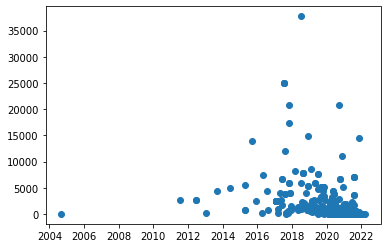

In [347]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['pro_date'], df['rating_count'])
plt.show() 

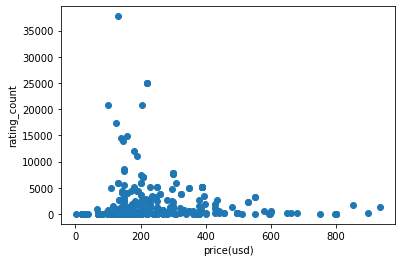

In [349]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['price'], df['rating_count'])
plt.xlabel('price(usd)')
plt.ylabel('rating_count')
plt.show() 

In [351]:
df_by_brand = df.groupby('brand').mean()
df_by_brand.head()

,page,order,rating_count,price,refresh_rate,size,avg_rating,5star_rating,4star_rating,3star_rating,2star_rating,1star_rating,Unnamed: 17
brand,,,,,,,,,,,,,
,12.666667,13.00,34.00,203.990000,NaN,NaN,4.733333,0.840,0.130000,NaN,NaN,0.030000,NaN
acer,12.333333,11.75,5918.25,195.629167,117.583333,24.941667,4.441667,0.720,0.144167,0.050,0.035833,0.057273,NaN
aishichen,3.000000,13.00,0.00,145.990000,75.000000,21.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alecewey,5.000000,6.00,89.00,399.990000,60.000000,12.000000,3.900000,0.580,0.110000,0.100,0.050000,0.150000,NaN
alienware,12.000000,10.25,990.25,398.247500,300.000000,25.250000,4.675000,0.855,0.060000,0.035,0.010000,0.035000,NaN


In [352]:
df_by_brand.describe()


,page,order,rating_count,price,refresh_rate,size,avg_rating,5star_rating,4star_rating,3star_rating,2star_rating,1star_rating,Unnamed: 17
count,68.000000,68.000000,68.000000,67.000000,60.000000,65.000000,66.000000,66.000000,61.000000,56.000000,51.000000,58.000000,0.0
mean,12.071610,11.343364,1078.835089,239.228892,86.764858,19.680145,4.381084,0.710908,0.148762,0.076468,0.049522,0.084472,NaN
std,3.848662,4.857760,2247.149281,148.088137,45.677346,7.738102,0.416848,0.146166,0.049230,0.055783,0.061044,0.079451,NaN
min,2.000000,1.000000,0.000000,18.990000,60.000000,3.500000,3.000000,0.356818,0.060000,0.010000,0.010000,0.010000,NaN
25%,9.968750,7.437500,28.000000,146.323333,60.000000,15.000000,4.125000,0.632500,0.120000,0.040000,0.019286,0.040000,NaN
50%,12.666667,11.062500,105.000000,199.990000,60.000000,17.300000,4.500000,0.738000,0.138500,0.052411,0.030000,0.053750,NaN
75%,15.000000,14.500000,1078.875000,321.920000,100.166667,25.250000,4.645833,0.798333,0.170000,0.105000,0.060000,0.097500,NaN
max,19.000000,22.000000,10982.000000,799.990000,300.000000,49.000000,5.000000,1.000000,0.310000,0.244231,0.353846,0.460000,NaN


In [358]:
df_by_brand_over_mean = df_by_brand[df_by_brand['rating_count']>105]


<BarContainer object of 34 artists>

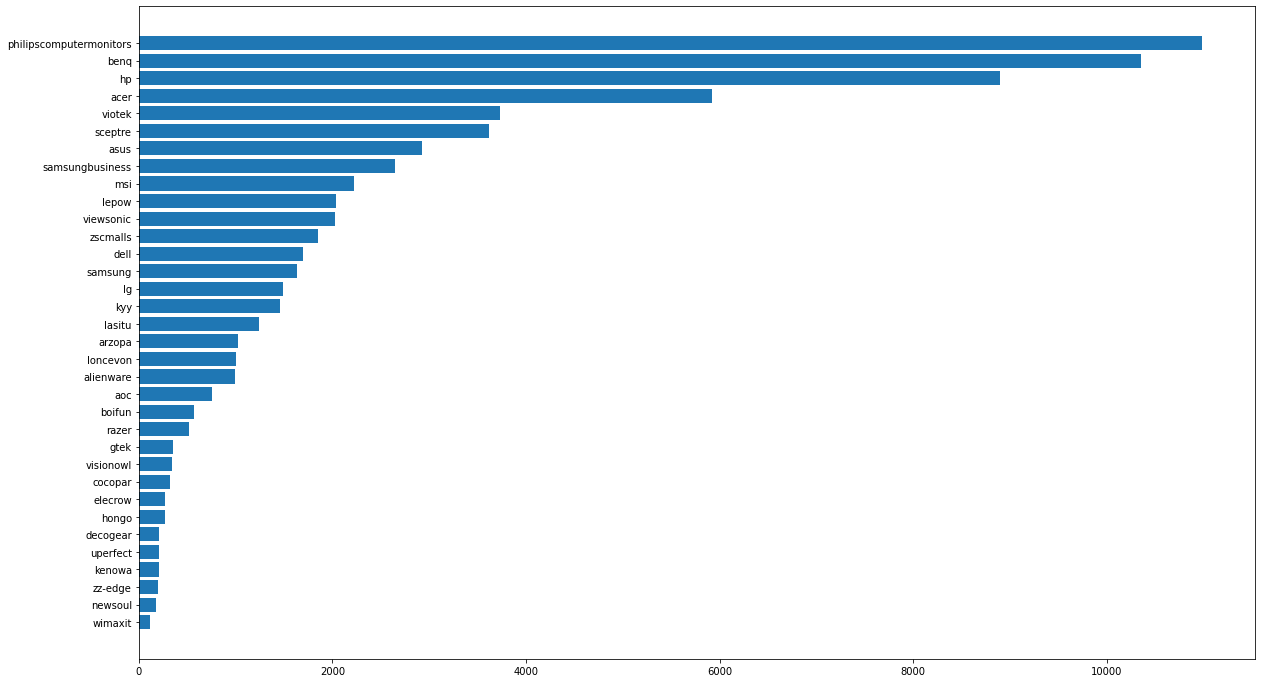

In [363]:
df_by_brand_over_mean = df_by_brand_over_mean.sort_values(by= ['rating_count'])

fig = plt.figure(figsize=(20,12)) 

plt.barh(df_by_brand_over_mean.index,df_by_brand_over_mean['rating_count'])

<BarContainer object of 34 artists>

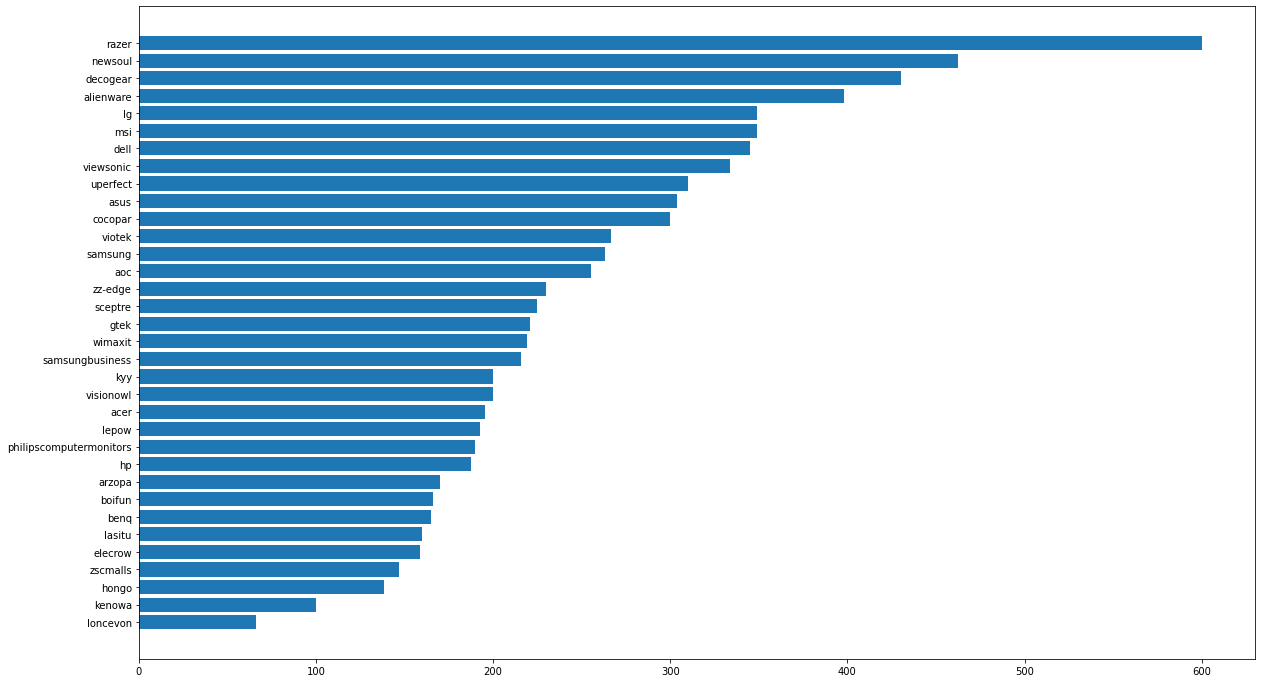

In [364]:
df_by_brand_over_mean = df_by_brand_over_mean.sort_values(by= ['price'])
fig = plt.figure(figsize=(20,12))
plt.barh(df_by_brand_over_mean.index,df_by_brand_over_mean['price'])

# 文字欄處理

In [365]:
goods_spcs_type = []
new_goods_spcs = []
for goods_spcs in df['goods_spcs']:
    goods_spcs = re.sub(r"['\[\]\s]","",goods_spcs.lower())
    goods_spcs = goods_spcs.replace('，',',')
    goods_spcs = goods_spcs.replace(';',',')
    goods_spcs = goods_spcs.split(',')
    new_goods_spcs.append(goods_spcs)
    for each_goods_spcs in goods_spcs:
        if each_goods_spcs == '':
            continue
        goods_spcs_type.append(each_goods_spcs)



In [366]:
df['goods_spcs'] = new_goods_spcs

In [367]:
df.head()

,id,page,order,rating_count,price,brand,goods_spcs,refresh_rate,size,avg_rating,5star_rating,4star_rating,3star_rating,2star_rating,1star_rating,review_key_word,pro_date,Unnamed: 17,item_url
0,B082DNTXJ6,1,1,2510,149.99,viotek,[gaming],144.0,22.0,4.5,0.75,0.14,0.04,0.01,0.05,"['sdisplay port', 'picture quality', 'refresh ...",2017-01-19,NaN,https://www.amazon.com/gp/slredirect/picassoRe...
1,B09QRJP42S,1,2,8,102.99,prechen,[],60.0,18.5,3.2,0.33,0.14,0.14,0.15,0.24,[],2022-01-20,NaN,https://www.amazon.com/gp/slredirect/picassoRe...
2,B0773ZY26F,1,3,17437,125.00,sceptre,"[multimedia, personal, business]",60.0,24.0,4.6,0.77,0.14,0.04,0.01,0.03,"['spicture quality', 'dead pixels', 'home offi...",2017-11-01,NaN,https://www.amazon.com/Sceptre-E248W-19203R-Mo...
3,B07743412C,1,4,20803,99.99,sceptre,"[multimedia, personal, business]",60.0,20.0,4.5,0.73,0.16,0.06,0.02,0.04,"['spicture quality', 'working from home', 'eas...",2017-11-01,NaN,https://www.amazon.com/Sceptre-E205W-16003R-Fr...
4,B078HMK7S3,1,5,1418,115.63,sceptre,"[business, home, officeandgaming]",75.0,20.0,4.4,0.67,0.17,0.08,0.03,0.05,"['sworks great', 'picture quality', 'work from...",2017-12-19,NaN,https://www.amazon.com/Sceptre-Monitor-1600x90...


In [368]:
df_goods_type_count = pd.value_counts(goods_spcs_type)
df_goods_type_count

gaming                    213
business                  195
personal                  139
multimedia                 72
education                  50
videoediting               47
photoediting               39
programming                31
travel                      4
extendedscreen              3
office                      3
multi-screen                3
typecmonitor                2
computermonitor             2
home                        2
eduction                    2
monitors                    2
portablescreendisplay       2
etc.                        1
4kportablemonitor           1
portablemonitor             1
industrialequipment         1
stock                       1
secondscreen                1
videomakers                 1
photography                 1
school                      1
dslrfieldcameramonitor      1
homeviewing                 1
personalandbusiness         1
officeandgaming             1
student                     1
entrepreneurs               1
15.6"monit

(array([619.,  54., 118.,   6.,   8.,   7.,   7.,   5.,   4.,   4.]),
 array([ 0. ,  3.8,  7.6, 11.4, 15.2, 19. , 22.8, 26.6, 30.4, 34.2, 38. ]),
 <BarContainer object of 10 artists>)

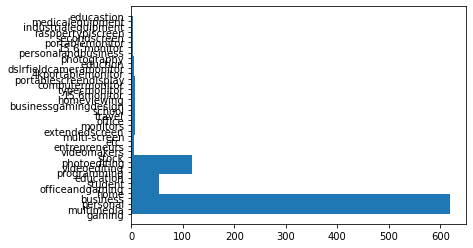

In [369]:
plt.hist(goods_spcs_type,orientation = 'horizontal')